<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

<h2 style="text-align: left; background-color:#1192AA; font-family: Georgia; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; text-align: center; font-size: 25px; border-radius: 100px 100px;">TABLE OF CONTENTS</h2>

* &nbsp; **[Import](#IMPORT-AND-LOAD-DATA)**


* &nbsp; **[Load Data](#Load-Data)**


* &nbsp; **[Basic EDA](#EDA)**


* &nbsp; **[Feature Engineering](#Feature-Engineering)**


* &nbsp; **[Model Building](#Model-Building)**


* &nbsp; **[Make Submission](#Make-Submission)**


* &nbsp; **[Acknowledgements](#Acknowledgements)**


# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Import</h2>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
#from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, NMF
from umap import UMAP
from sklearn.manifold import TSNE

# Import libraries for Hypertuning
import optuna
from joblib import Parallel, delayed

# More models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Load Data</h2>

In [2]:
filepath = '/kaggle/input/playground-series-s3e13'
origin_filepath = '/kaggle/input/vector-borne-disease-prediction/trainn.csv'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])

original = pd.read_csv(origin_filepath)
original.prognosis = original.prognosis.str.replace(' ', '_')

# df_train['is_generated'] = 1
# df_test['is_generated'] = 1
# original['is_generated'] = 0

# original.prognosis = original.prognosis.str.replace(' ', '_')
# df_concat = pd.concat([df_train, original], axis=0).reset_index(drop=True)

df_concat = df_train.copy()

target_col = 'prognosis'

# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">EDA</h2>

In [3]:
# Create figure
fig = px.histogram(df_train['prognosis'],
                   template='plotly_dark',
                   color_discrete_sequence = ['#1192AA'])



# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Train Prognosis Distribution",
        'y':0.95,
        'x':0.5
        }
    )

# Display
fig.show()

In [4]:
# Create figure
fig = px.histogram(original['prognosis'],
                   template='plotly_dark',
                   color_discrete_sequence = ['#1192AA'])



# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Oririn Prognosis Distribution",
        'y':0.95,
        'x':0.5
        }
    )

# Display
fig.show()

In [5]:
# Create figure
fig = px.imshow(df_train.corr(), template='plotly_dark')

# Set Title and x/y axis labels
fig.update_layout(
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Train Dataset Correlation",
        'y':0.95,
        'x':0.49
        }
    )

# Display
fig.show() 

In [6]:
# Create figure
fig = px.imshow(original.corr(), template='plotly_dark')

# Set Title and x/y axis labels
fig.update_layout(
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Original Dataset Correlation",
        'y':0.95,
        'x':0.49
        }
    )

# Display
fig.show() 

In [7]:
def plot_countplots(df, num_cols, palette):
    num_rows = (len(df_test.columns)) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
    sns.set(font_scale=1.2, style='white')

    for i, col_name in enumerate(df_test.columns):
        #if (col_name != 'is_generated') or (col_name != target_col):
        ax = axes[(i-1) // num_cols, (i-1) % num_cols]
        sns.countplot(data=df, x=col_name, ax=ax, palette=palette)
        ax.set_title(f'{col_name.title()}', fontsize=18)
        ax.set_xlabel(col_name.title(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        sns.despine()

    plt.tight_layout()
    plt.show()

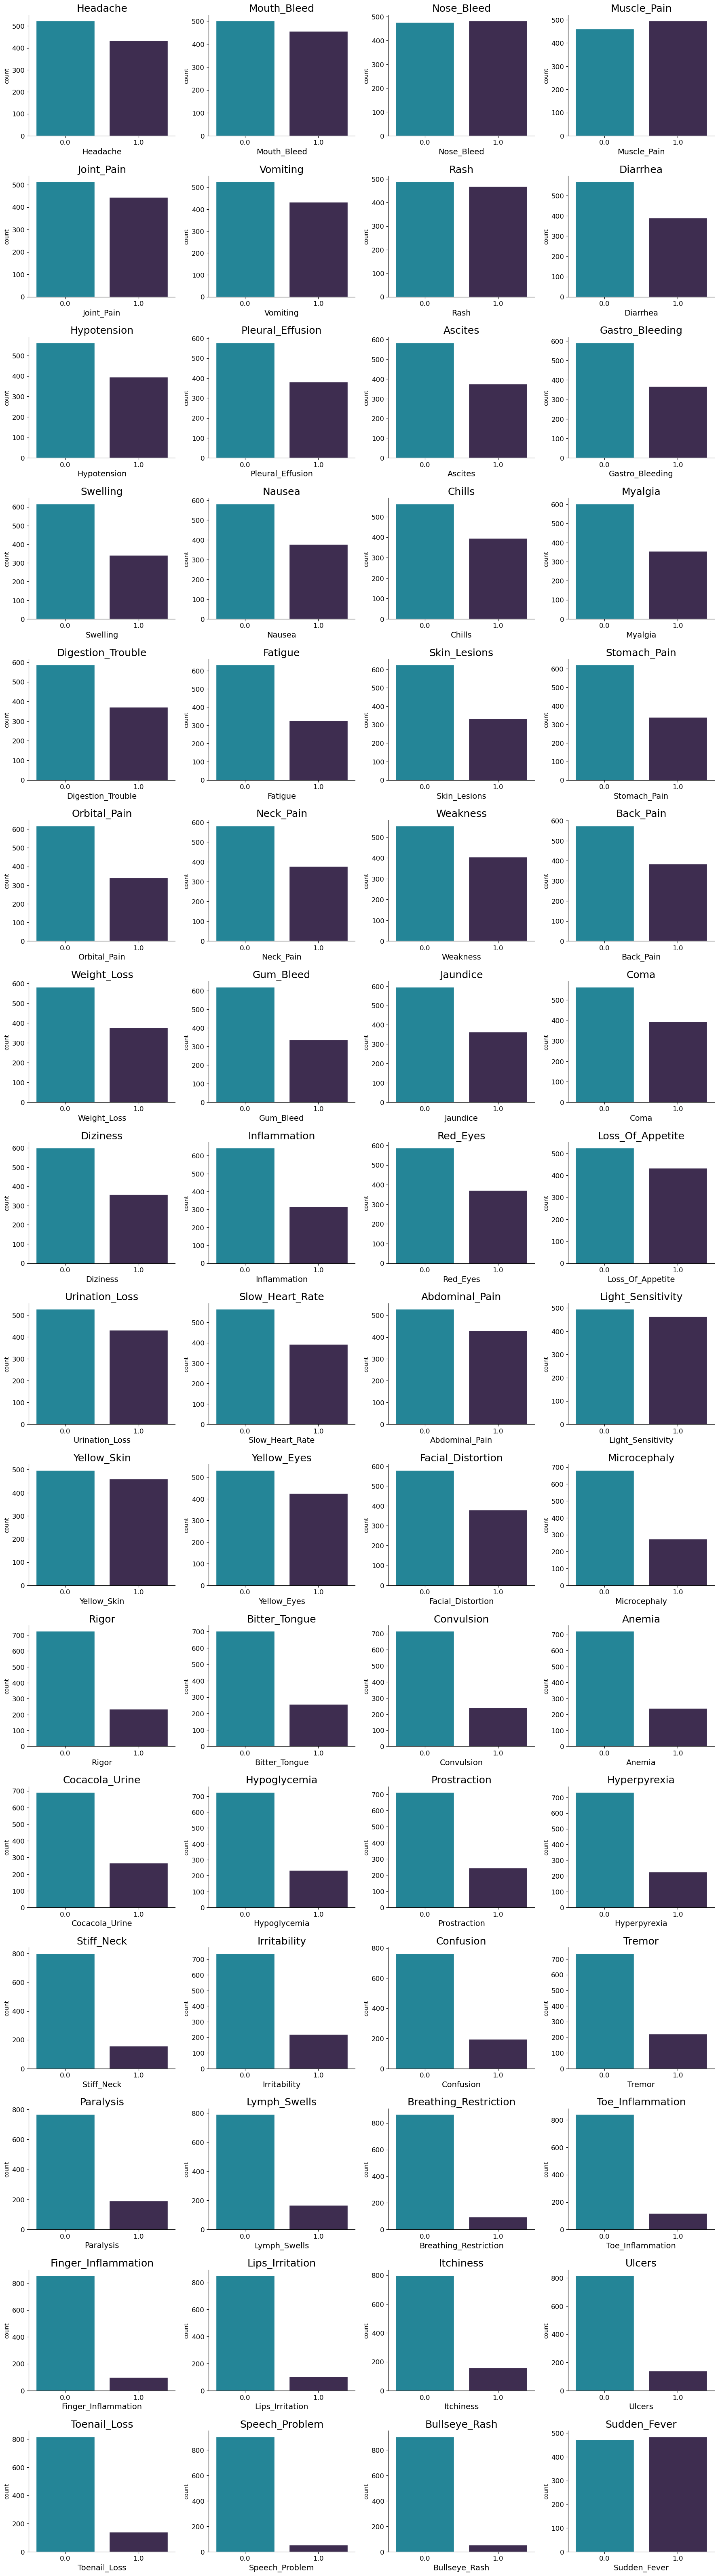

In [8]:
my_palette = ['#1192AA','#3E2756']
plot_countplots(pd.concat([df_train, original], axis=0).reset_index(drop=True), 4, my_palette)

# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Feature Engineering</h2>

In [9]:
# # https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e13-2023-eda-and-submission
# pain = df_concat.columns[df_concat.columns.str.contains('pain')]
# inflammation = df_concat.columns[df_concat.columns.str.contains('inflammation')]
# bleeding = df_concat.columns[df_concat.columns.str.contains('bleed')]
# skin = df_concat.columns[df_concat.columns.str.contains('bleed')].tolist() + ['itchiness']

similar_columns = [
    'loss_of_appetite',
    'urination_loss',
    'slow_heart_rate',
    'abdominal_pain', 
    'light_sensitivity',
    'yellow_skin',
    'yellow_eyes'
]

chikungunya_columns = [
    'convulsion',
    'finger_inflammation',
    'speech_problem',
    'toenail_loss',
    'ulcers', 
    'itchiness',
    'lips_irritation',
    'breathing_restriction',
    'toe_inflammation',
    'paralysis',
    'stomach_pain',
    'confusion',
    'irritability',
    'bullseye_rash'
]

lyme_columns = [
    'jaundice',
    'weight_loss',
    'weakness',
    'back_pain',
    'sudden_fever', 
    'myalgia',
    'chills',
    'orbital_pain',
    'digestion_trouble'
]

red_cols = [
    'diarrhea',
    'hypotension',
    'pleural_effusion',
    'ascites', 
    'gastro_bleeding',
    'swelling',
    'nausea', 
    'chills', 
    'myalgia', 
    'digestion_trouble',
    'fatigue', 
    'skin_lesions', 
    'stomach_pain',
    'orbital_pain',
    'neck_pain', 
    'weakness', 
    'back_pain', 
    'weight_loss', 
    'gum_bleed', 
    'jaundice', 
    'coma',
    'diziness',
    'inflammation',
    'red_eyes',
    'loss_of_appetite',
    'urination_loss',
    'slow_heart_rate',
    'abdominal_pain', 
    'light_sensitivity',
    'yellow_skin',
    'yellow_eyes', 
    'facial_distortion', 
    'microcephaly'
]

orange_cols = [
    'rigor',
    'bitter_tongue',
    'convulsion',
    'anemia',
    'cocacola_urine',
    'hypoglycemia',
    'prostraction',
    'hyperpyrexia',
    'stiff_neck',
    'irritability',
    'confusion',
    'tremor',
    'paralysis',
    'lymph_swells',
    'breathing_restriction',
    'toe_inflammation',
    'finger_inflammation',
    'lips_irritation',
    'itchiness',
    'ulcers',
    'toenail_loss',
    'speech_problem',
    'bullseye_rash'
]

green_cols = [
    'sudden_fever',
    'headache',
    'mouth_bleed',
    'nose_bleed',
    'muscle_pain',
    'joint_pain',
    'vomiting',
    'rash']

# Implementing features
for df in [df_concat, df_test]:
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    #df['pain'] = df[pain].sum(axis=1)
    #df['skin'] = df[skin].sum(axis=1)
    #df['inflammation'] = df[inflammation].sum(axis=1)
    #df['bleeding'] = df[bleeding].sum(axis=1)
    df['red_cols'] = df[red_cols].sum(axis=1)
    df['orange_cols'] = df[orange_cols].sum(axis=1)
    df['green_cols'] = df[green_cols].sum(axis=1)

for df in [df_concat, df_test]: 
    tungiasis_columns = ['ulcers', 'toenail_loss', 'itchiness']
    df['tungiasis_cluster'] = df[tungiasis_columns].sum(axis=1)
    
    columns = [col for col in df if col != 'prognosis']
    df[columns] = df[columns].astype(int)

### Decomp:

In [10]:
class Decomp:
    def __init__(self, n_components, method="pca", scaler_method='standard'):
        self.n_components = n_components
        self.method = method
        self.scaler_method = scaler_method
        
    def dimension_reduction(self, df):
            
        X_reduced = self.dimension_method(df)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
        return df_comp
    
    def dimension_method(self, df):
        
        X = self.scaler(df)
        if self.method == "pca":
            comp = PCA(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "nmf":
            comp = NMF(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "umap":
            comp = UMAP(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "tsne":
            comp = TSNE(n_components=self.n_components, random_state=0) # Recommend n_components=2
            X_reduced = comp.fit_transform(X)
        else:
            raise ValueError(f"Invalid method name: {method}")
        
        self.comp = comp
        return X_reduced
    
    def scaler(self, df):
        
        _df = df.copy()
            
        if self.scaler_method == "standard":
            return StandardScaler().fit_transform(_df)
        elif self.scaler_method == "minmax":
            return MinMaxScaler().fit_transform(_df)
        elif self.scaler_method == None:
            return _df.values
        else:
            raise ValueError(f"Invalid scaler_method name")
        
    def get_columns(self):
        return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
    
    def transform(self, df):
        X = self.scaler(df)
        X_reduced = self.comp.transform(X)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
        return df_comp
    
    @property
    def get_explained_variance_ratio(self):
        
        return np.sum(self.comp.explained_variance_ratio_)

In [11]:
# Create a dictionary mapping each disease name to a corresponding integer value
target_map = {
    'Lyme_disease': 0,
    'Tungiasis': 1,
    'Zika': 2,
    'Rift_Valley_fever': 3,
    'West_Nile_fever': 4,
    'Malaria': 5,
    'Chikungunya': 6,
    'Plague': 7,
    'Dengue': 8,
    'Yellow_Fever': 9,
    'Japanese_encephalitis': 10
}
swapped_map = {v: k for k, v in target_map.items()}
df_concat[target_col] = df_concat[target_col].replace(target_map).astype(int)

# Concatenate train and original dataframes, and prepare train and test sets
drop_columns = [] # 'is_generated'
X_train = df_concat.drop([target_col]+drop_columns, axis=1).reset_index(drop=True).astype(int)
y_train = df_concat[target_col].reset_index(drop=True)
X_test = df_test.drop(drop_columns, axis=1).reset_index(drop=True).astype(int)

# X_train_ori, X_test_ori = X_train.copy(), X_test.copy()

# # Add dimension_reduction Featrues
# umap_n_components = 5
# decomp = Decomp(n_components=umap_n_components, method='umap', scaler_method=None)
# umap_train = decomp.dimension_reduction(X_train).reset_index(drop=True)
# umap_test = decomp.transform(X_test).reset_index(drop=True)
# print(f'  --> UMAP(n_components={umap_n_components})')

# # Concat Data
# X_train = pd.concat([X_train_ori, umap_train], axis=1).reset_index(drop=True)
# X_test = pd.concat([X_test_ori, umap_test], axis=1).reset_index(drop=True)
# # X_train, X_test = X_train_ori.copy(), X_test_ori.copy()

print("")
print(f"X_train shape :{X_train.shape}")
print(f"y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test, original

X_train.head(5)


X_train shape :(707, 71)
y_train shape :(707,)
X_test shape :(303, 71)


,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,toenail_loss,speech_problem,bullseye_rash,similar_cluster,chikungunya_columns,lyme_columns,red_cols,orange_cols,green_cols,tungiasis_cluster
0,1,1,0,1,1,1,1,0,1,1,...,0,0,0,1,3,6,17,5,6,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,5,0,1,0
2,0,1,1,1,0,1,1,1,1,1,...,1,1,1,5,13,7,27,18,6,2
3,0,0,1,1,1,1,0,1,0,1,...,0,0,0,3,1,5,21,2,5,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,4,0,2,4,0,3


# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Model Building</h2>

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Optimizer (MAP@3):</h2>

In [12]:
#https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook
def apk(actual, predicted, k=10):
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Splitter:</h2>

In [13]:
class Splitter:
    def __init__(self, kfold=True, n_splits=10):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">XGBoost, LGBM and CatBoost Hypertune:</h2>

This is code I used to hypertune my models, I also tried to hypertune them on different datasets with different feature engineering approaches.

```python
# Load data and define target and features
data = pd.DataFrame(y_train).join(X_train)
target = y_train
features = X_train

# Define params
n_splits = 10
n_trials = 100
early_stopping_rounds = 333

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 10.0),
        'n_jobs': -1,
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'tree_method': 'hist',
        'verbosity': 0,
        'random_state': 42
     }
    
    lgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 10.0),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 10, 100),
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'device': "cpu",
        'random_state': 42
    }
    
    cat_params = {
        'iterations': self.n_estimators,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.1, 1.0),
        'max_bin': trial.suggest_int('max_bin', 100, 500),
        'od_wait': trial.suggest_int('od_wait', 20, 100),
        'one_hot_max_size': 70,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'eval_metric': 'MultiClass',
        'loss_function': 'MultiClass',
        'random_state': 42
    }
        
    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize list to store MAP@3 scores for each fold
    map3_scores = []
    
    # Loop over folds in parallel
    results = Parallel(n_jobs=-1)(delayed(get_fold_score)(params, features, target, train_idx, valid_idx, early_stopping_rounds) for train_idx, valid_idx in kf.split(data))
    map3_scores = [r[0] for r in results]
    
    # Return negative mean of MAP@3 scores (Optuna maximizes the objective)
    return np.mean(map3_scores)

# Define function to get MAP@3 score for a fold
def get_fold_score(params, features, target, train_idx, valid_idx, early_stopping_rounds):
    # Split data into training and validation sets
    X_train, X_valid = features.iloc[train_idx], features.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    # Initialize XGBoost model
    model = xgb.XGBClassifier(**params)
    
#    model = lgb.LGBMClassifier(**params)
    
#    model = CatBoostClassifier(**params)
    
   
    # Fit model on training data
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stopping_rounds, verbose=False)

    # Predict probabilities for validation data
    y_pred = model.predict_proba(X_valid)
    top_preds = np.argsort(-y_pred, axis=1)[:, :3]

    # Calculate MAP@3 score for validation data
    map3 = mapk(y_valid.values.reshape(-1, 1), top_preds, 3)

    return (map3,)

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and their score
print('Best hyperparameters: {}'.format(study.best_params))
print('Best score: {}'.format(study.best_value))
```

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Define Models:</h2>

In [14]:
class Classifier:
    def __init__(self, n_estimators=250, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': 950,
            'learning_rate': 0.15639672008038652,
            'max_depth': 9,
            'subsample': 0.7154363211099006,
            'colsample_bytree': 0.1834688802646254,
            'reg_alpha': 0.00662736159424831,
            'reg_lambda': 0.392111943900896,
            'n_jobs': -1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state
        }
        
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        
        lgb_params = {
            'n_estimators': 650,
            'max_depth': 6,
            'learning_rate': 0.09800555723996654,
            'subsample': 0.5113976179887376,
            'colsample_bytree': 0.15594697300978008,
            'reg_alpha': 0.24312642991831,
            'reg_lambda': 0.06500132210882924,
            'one_hot_max_size': 95,
            'device': self.device,
            'random_state': self.random_state}
                
        
        cb_params = {
            'n_estimators': 1000,
            'depth': 9, 
            'learning_rate': 0.45645253367049604,
            'l2_leaf_reg': 8.407202048380578,
            'random_strength': 0.1793388390086202,
            'max_bin': 225, 
            'od_wait': 58, 
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
                
        models = {
            'svc': SVC(gamma="auto", probability=True, random_state=self.random_state),
#             'svc_li': SVC(kernel="linear", gamma="auto", probability=True, random_state=self.random_state),
#             'svc_po': SVC(kernel="poly", gamma="auto", probability=True, random_state=self.random_state),
#             'svc_si': SVC(kernel="sigmoid", gamma="auto", probability=True, random_state=self.random_state),
            'lr': LogisticRegression(max_iter=150, random_state=self.random_state, n_jobs=-1),
            'xgb': xgb.XGBClassifier(**xgb_params),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'cat': CatBoostClassifier(**cb_params),
            'brf': BalancedRandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=200, random_state=self.random_state),
           # 'knn': KNeighborsClassifier(n_neighbors=5),
           # 'mlp': MLPClassifier(random_state=self.random_state, max_iter=1000),
           # 'xgb_0':xgb.XGBClassifier(random_state=self.random_state),
            #'lgb_0':lgb.LGBMClassifier(random_state=self.random_state),
            #'cat_0':CatBoostClassifier(random_state=self.random_state),
        }
        
        return models

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Ensemble Weights:</h2>

In [15]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=2000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-12, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)

        # Calculate the MAP@3 score for the weighted prediction
        top_preds = np.argsort(-weighted_pred, axis=1)[:, :3]
        score = mapk(y_true.reshape(-1, 1), top_preds, 3)
        
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='maximize') # minimize
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Train Model by K-fold:</h2>

In [16]:
kfold = True
n_splits = 1 if not kfold else 15
random_state = 42
random_state_list = [42]
n_estimators = 9999
early_stopping_rounds = 333
verbose = False
device = 'cpu'
atk = 3

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], len(y_train.unique())))
ensemble_score = []
ensemble_mapk_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[], 'rf':[]}
rank_df = pd.DataFrame(columns=swapped_map.keys(), index=X_test.index).fillna(0)

    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if name in ['xgb', 'lgb', 'cat', 'lgb2']:
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        top_preds = np.argsort(-y_val_pred, axis=1)[:, :atk]

        mapk_score = mapk(y_val.values.reshape(-1, 1), top_preds, atk)
        
        score = log_loss(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] MAP@{atk}: {mapk_score:.5f}, Logloss: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    top_preds = np.argsort(-y_val_pred, axis=1)[:, :atk]
    mapk_score = mapk(y_val.values.reshape(-1, 1), top_preds, atk)
    
    score = log_loss(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] MAP@{atk}: {mapk_score:.5f}, Logloss: {score:.5f}')
    
    ensemble_score.append(score)
    ensemble_mapk_score.append(mapk_score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    # Rank Prediction
    for i in range(_test_preds.shape[0]):
        arr = _test_preds[i]
        sorted_indices = np.argsort(arr)
        for k, p in zip(range(1, 10), [9, 8, 7, 6, 5, 4, 3, 2, 1]):
            second_largest_index = sorted_indices[-k]
            rank_df.loc[i, second_largest_index] += p
    
    gc.collect()

svc [FOLD-0 SEED-42] MAP@3: 0.38889, Logloss: 1.81883
lr [FOLD-0 SEED-42] MAP@3: 0.40278, Logloss: 1.95109
xgb [FOLD-0 SEED-42] MAP@3: 0.46181, Logloss: 1.83982
[LightGBM] [Warning] Unknown parameter: one_hot_max_size
lgb [FOLD-0 SEED-42] MAP@3: 0.44792, Logloss: 1.83214
cat [FOLD-0 SEED-42] MAP@3: 0.48264, Logloss: 1.72580
brf [FOLD-0 SEED-42] MAP@3: 0.37847, Logloss: 1.79531
rf [FOLD-0 SEED-42] MAP@3: 0.36806, Logloss: 1.78670
Ensemble [FOLD-0 SEED-42] MAP@3: 0.48958, Logloss: 1.74265
svc [FOLD-1 SEED-42] MAP@3: 0.31250, Logloss: 2.17057
lr [FOLD-1 SEED-42] MAP@3: 0.24653, Logloss: 2.75441
xgb [FOLD-1 SEED-42] MAP@3: 0.37500, Logloss: 2.09543
[LightGBM] [Warning] Unknown parameter: one_hot_max_size
lgb [FOLD-1 SEED-42] MAP@3: 0.33333, Logloss: 2.10094
cat [FOLD-1 SEED-42] MAP@3: 0.27083, Logloss: 2.15612
brf [FOLD-1 SEED-42] MAP@3: 0.30556, Logloss: 2.16405
rf [FOLD-1 SEED-42] MAP@3: 0.34722, Logloss: 2.68258
Ensemble [FOLD-1 SEED-42] MAP@3: 0.39583, Logloss: 2.10118
svc [FOLD-2 SEED

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Ensemble [FOLD-5 SEED-42] MAP@3: 0.50355, Logloss: 1.62566
svc [FOLD-6 SEED-42] MAP@3: 0.38298, Logloss: 1.90389
lr [FOLD-6 SEED-42] MAP@3: 0.29787, Logloss: 2.64922
xgb [FOLD-6 SEED-42] MAP@3: 0.37943, Logloss: 2.02395
[LightGBM] [Warning] Unknown parameter: one_hot_max_size
lgb [FOLD-6 SEED-42] MAP@3: 0.41135, Logloss: 1.96888
cat [FOLD-6 SEED-42] MAP@3: 0.36170, Logloss: 1.95728
brf [FOLD-6 SEED-42] MAP@3: 0.40071, Logloss: 1.96423
rf [FOLD-6 SEED-42] MAP@3: 0.30496, Logloss: 1.96402
Ensemble [FOLD-6 SEED-42] MAP@3: 0.43262, Logloss: 1.93436
svc [FOLD-7 SEED-42] MAP@3: 0.31915, Logloss: 1.99748
lr [FOLD-7 SEED-42] MAP@3: 0.36525, Logloss: 2.63788
xgb [FOLD-7 SEED-42] MAP@3: 0.36170, Logloss: 2.06162
[LightGBM] [Warning] Unknown parameter: one_hot_max_size
lgb [FOLD-7 SEED-42] MAP@3: 0.43617, Logloss: 1.92171
cat [FOLD-7 SEED-42] MAP@3: 0.36170, Logloss: 1.99542
brf [FOLD-7 SEED-42] MAP@3: 0.30851, Logloss: 2.02804
rf [FOLD-7 SEED-42] MAP@3: 0.39362, Logloss: 2.58970
Ensemble [FOLD-7

...

In [17]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
mean_mapk_score = np.mean(ensemble_mapk_score)
std_score = np.std(ensemble_score)
std_mapk_score = np.std(ensemble_mapk_score)
print(f'Ensemble MAP@{atk} {mean_mapk_score:.5f} ± {std_mapk_score:.5f}')
print(f'Ensemble Logloss {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Ensemble MAP@3 0.47439 ± 0.06423
Ensemble Logloss 1.81702 ± 0.15537
--- Model Weights ---
svc: 0.44439 ± 0.18349
lr: 0.34664 ± 0.29134
xgb: 0.55017 ± 0.27998
lgb: 0.57536 ± 0.28483
cat: 0.44121 ± 0.27832
brf: 0.49526 ± 0.28310
rf: 0.37872 ± 0.25749


<h2 style = "font-family: Georgia;font-weight: bold; font-size: 19px; color: #1192AA; text-align:left">Visualize Feature importance (XGBoost, LightGBM, Catboost):</h2>

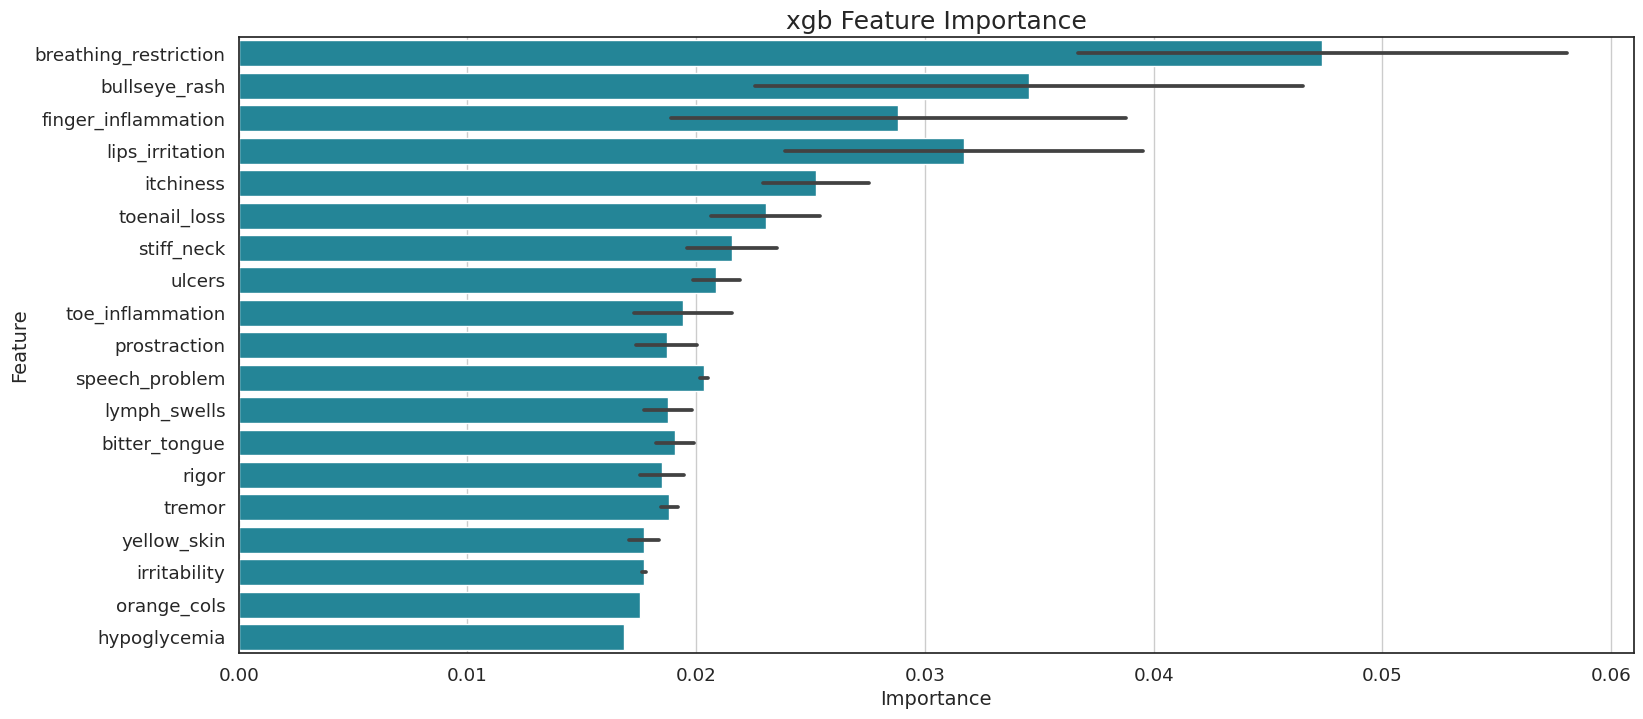

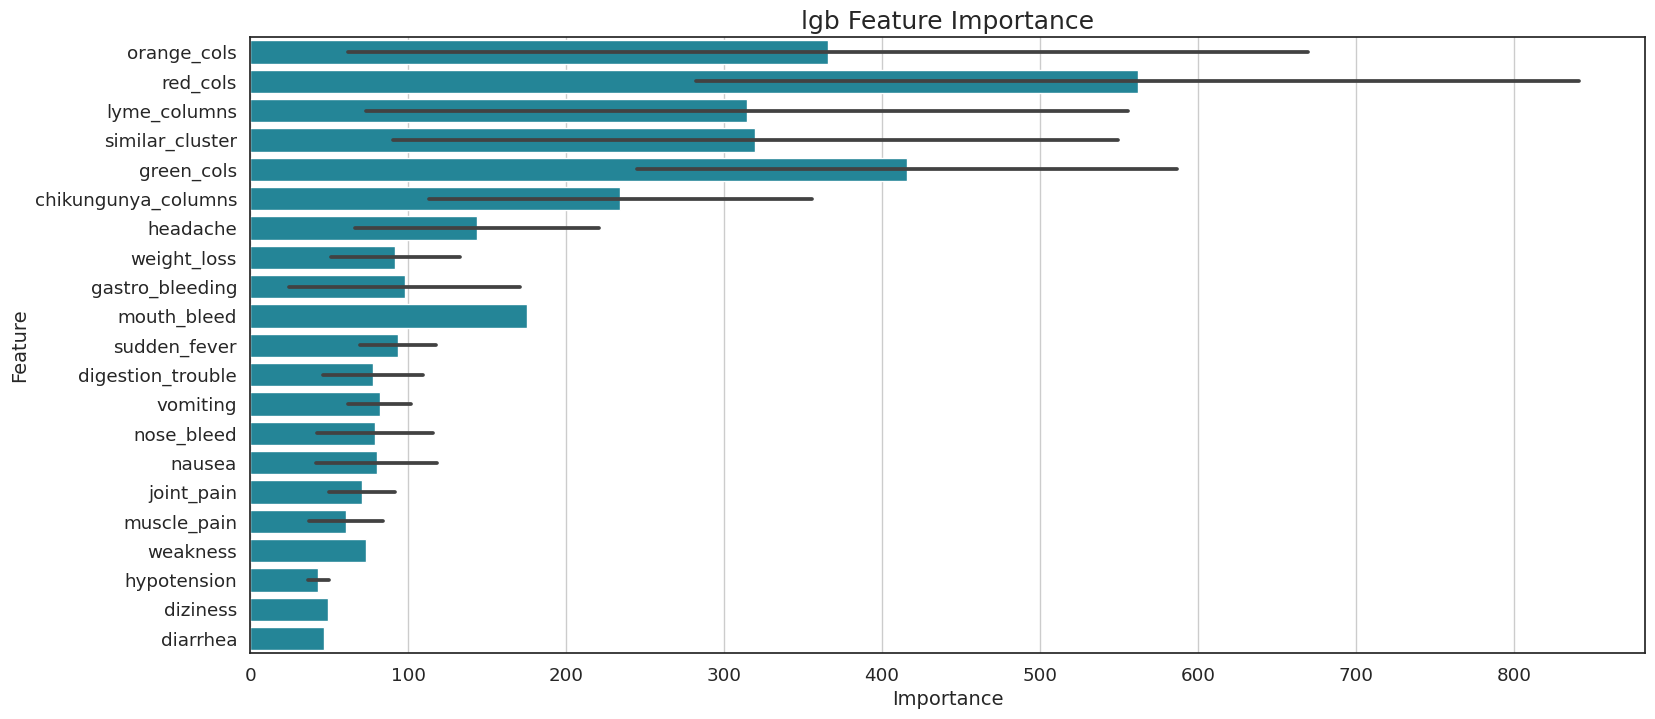

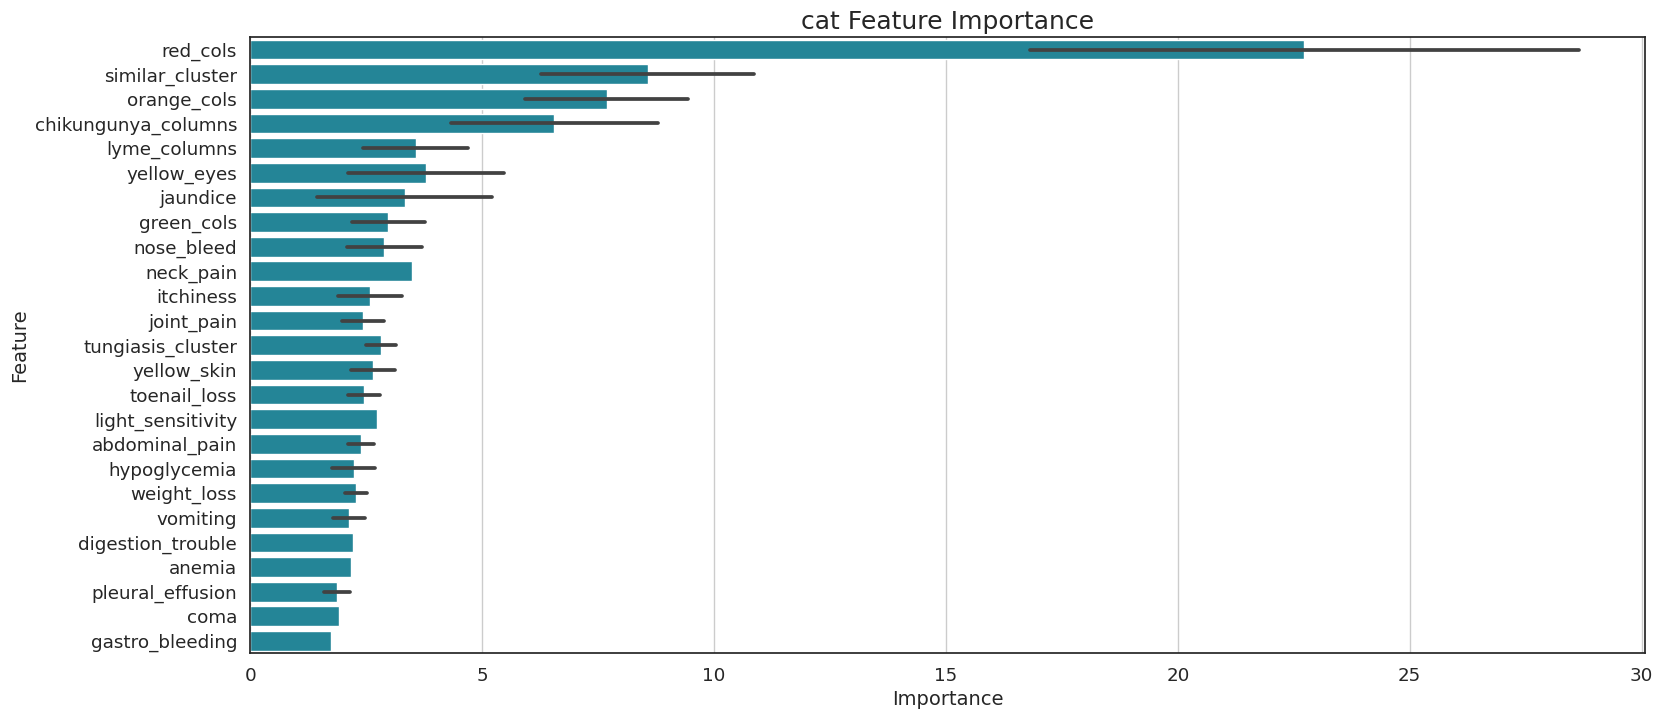

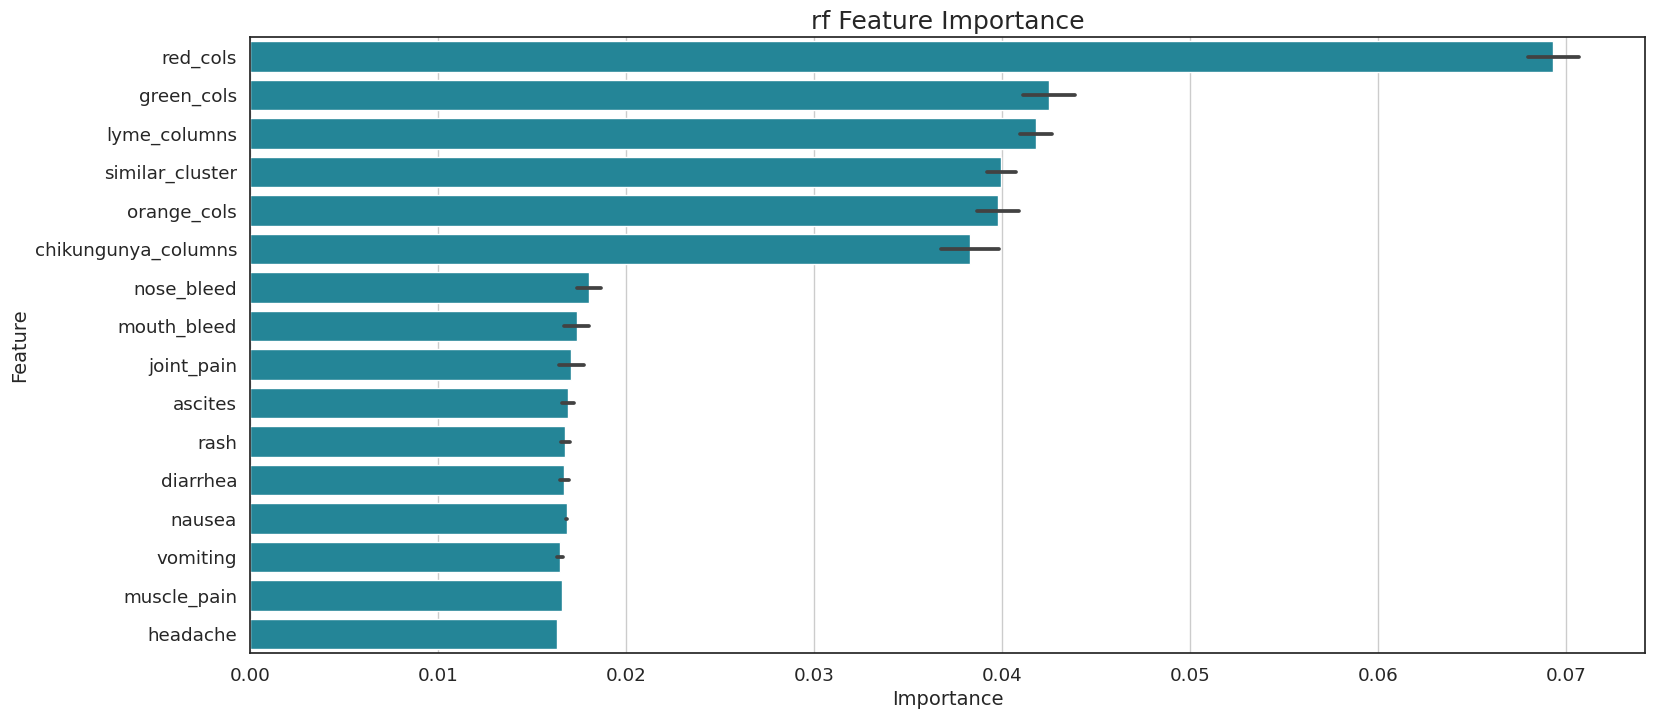

In [18]:
def visualize_importance(models, feature_cols, title, head=10):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(head)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(18, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='#1192AA', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Make Submission</h2>

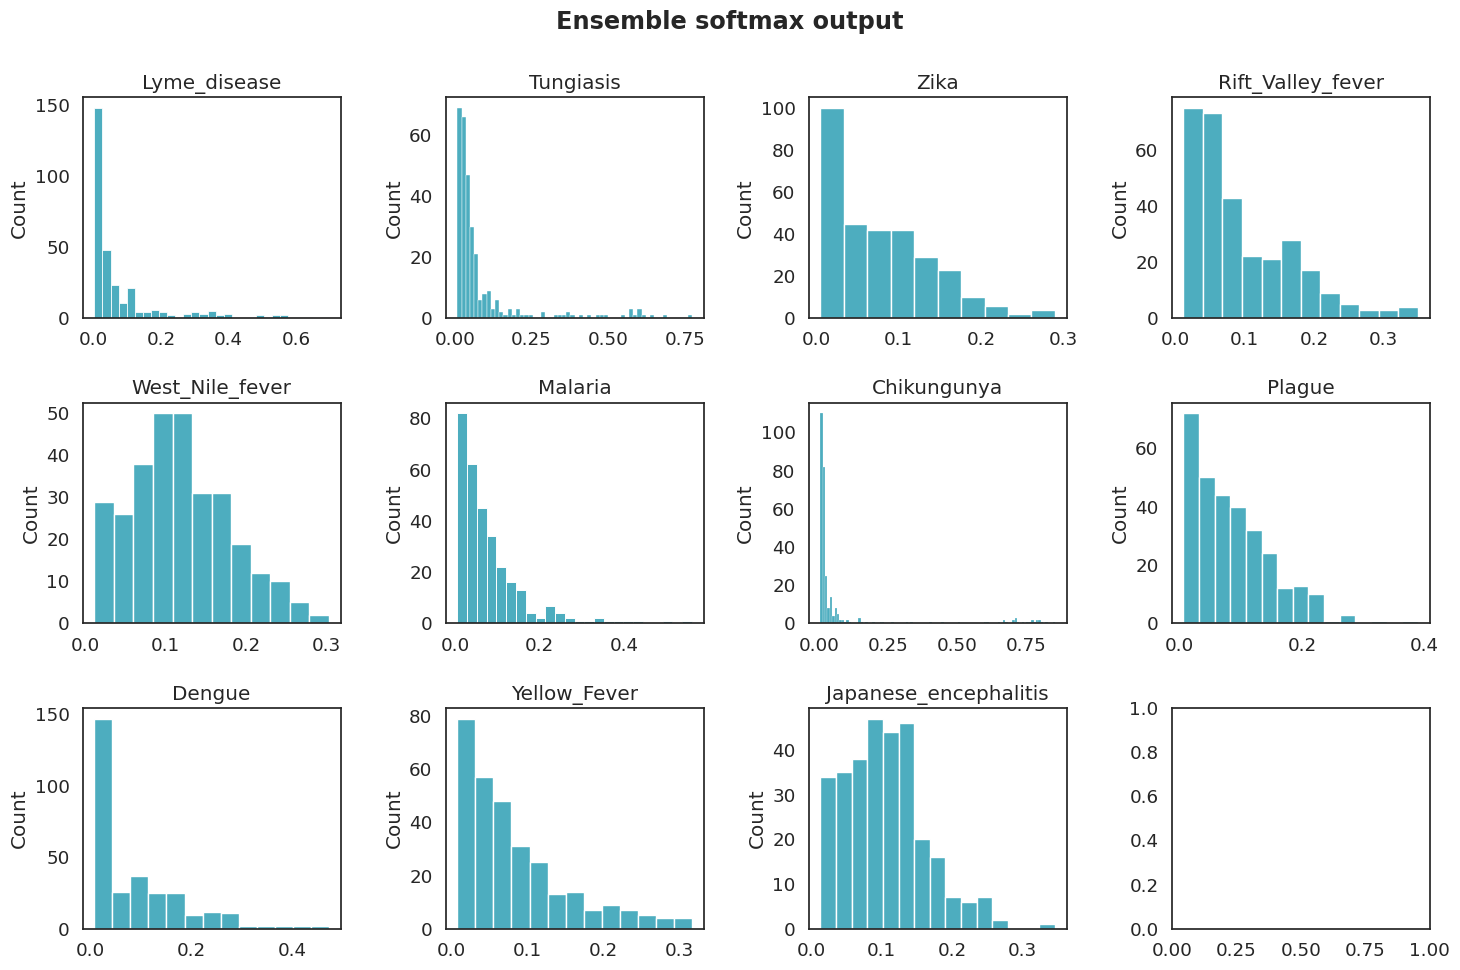

In [19]:
n_cols = 4
n_rows = np.ceil(test_predss.shape[1] / n_cols).astype(int)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.ravel()

for i in range(test_predss.shape[1]):
    sns.histplot(data=test_predss[:, i], ax=axs[i], color='#1192AA')
    axs[i].set_title(f"{swapped_map[i]}")
    
fig.suptitle(f'Ensemble softmax output', fontweight='bold')
fig.tight_layout(pad=1.5)
plt.show()

In [20]:
sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
for i in range(test_predss.shape[0]):
    rank_list = list(rank_df.iloc[i, :].sort_values(0, ascending=False).iloc[:3].index)
    sub.loc[i, 'prognosis'] = ' '.join([swapped_map[_] for _ in rank_list])
    
# Save submission file
sub.to_csv('submission_rank.csv', index=False)
sub

,id,prognosis
0,707,Rift_Valley_fever Tungiasis Dengue
1,708,Chikungunya Dengue Malaria
2,709,West_Nile_fever Japanese_encephalitis Rift_Val...
3,710,Japanese_encephalitis Rift_Valley_fever Tungiasis
4,711,West_Nile_fever Malaria Japanese_encephalitis
...,...,...
298,1005,Yellow_Fever Plague Zika
299,1006,Malaria Lyme_disease Plague
300,1007,Lyme_disease West_Nile_fever Malaria
301,1008,Rift_Valley_fever Japanese_encephalitis West_N...


# <h2 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Acknowledgements</h2>

* Big credit to [@tetsu2131](https://www.kaggle.com/tetsutani) and his public notebook https://www.kaggle.com/code/tetsutani/ps3e13-eda-decomposition-ensemble-rankpredict as I used a lot of his code and used his notebook as a base for my work.
* Thanks to [@belati](https://www.kaggle.com/belati) and his discussion topic https://www.kaggle.com/competitions/playground-series-s3e13/discussion/404958 for feature engineering ideas.
* Thanks to [@sergiosaharovskiy](https://www.kaggle.com/sergiosaharovskiy) and his public notebook https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e13-2023-eda-and-submission for great EDA and data insights.